In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<IPython.core.display.Javascript object>

# Define methods

In [3]:
def read_face_data_record(record: dict) -> dict:
    return {
        "is_face_detected": record["is_face_detected"],
        "angry": record["emotions"]["angry"],
        "disgust": record["emotions"]["disgust"],
        "fear": record["emotions"]["fear"],
        "happy": record["emotions"]["happy"],
        "sad": record["emotions"]["sad"],
        "neutral": record["emotions"]["neutral"],
        "head_turn": record["head_turn"],
        "eyes_closed": record["eyes_closed"],
    }

<IPython.core.display.Javascript object>

In [4]:
def output_metric(metric: str, dfs: list, smooth_span=1) -> None:
    f, ax = plt.subplots(figsize=(14, 3))
    for df in dfs:
        ax.plot(df[metric].ewm(span=smooth_span).mean())

<IPython.core.display.Javascript object>

In [5]:
def get_signal_df_list(data_files: list) -> list:
    face_data_signals = []
    for data_file in data_files:
        with open(data_file) as f:
            face_data = pd.DataFrame(
                [read_face_data_record(json.loads(line)) for line in f]
            )
        face_data_signals.append(face_data)
    return face_data_signals

<IPython.core.display.Javascript object>

In [6]:
def merge_on_metric(
    face_data_signals: list,
    attr_name: str,
    column_names: list,
    smoothing_window: int,
    min_len: int,
) -> pd.DataFrame:
    res_df = (
        pd.DataFrame(
            [face_data[attr_name][:min_len] for face_data in face_data_signals],
        )
        .T.ewm(span=smoothing_window)
        .mean()
    )
    res_df.columns = column_names
    return res_df

<IPython.core.display.Javascript object>

In [7]:
def crosscorr(data_x, data_y, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    data_x = pd.Series(data_x)
    data_y = pd.Series(data_y)

    if wrap:
        shifted_y = data_y.shift(lag)
        shifted_y.iloc[:lag] = data_y.iloc[-lag:].values
        return data_x.corr(shifted_y)
    else:
        return data_x.corr(data_y.shift(lag))

<IPython.core.display.Javascript object>

In [8]:
def get_shifted_correlations(data_1, data_2, shift_window: int):
    shift_ranges = range(-shift_window, shift_window)

    rs = [crosscorr(data_1, data_2, lag) for lag in shift_ranges]
    return rs, shift_ranges

<IPython.core.display.Javascript object>

In [9]:
def shifted_corr(data_1, data_2):
    rs, shift_ranges = get_shifted_correlations(
        data_1, data_2, shift_window=smoothing_window
    )
    return np.max(rs)

<IPython.core.display.Javascript object>

# Analysis

### Load data 

In [10]:
data_files = [
    "uhmm_video_1.json",
    "uhmm_video_2.json",
    "uhmm_video_3.json",
    "uhmm_video_4.json",
    "face_data.json",
    #     "face_data2.json",
    #     "french_lesson.json",
]
# data_files = ["fake_happy1.json", "fake_happy2.json", "fake_happy3.json"]
face_data_signals = get_signal_df_list(data_files)

<IPython.core.display.Javascript object>

In [11]:
min_len = min([face_data_signal.shape[0] for face_data_signal in face_data_signals])
min_len

3758

<IPython.core.display.Javascript object>

In [12]:
smoothing_window = int(min_len * 0.08)
smoothing_window

300

<IPython.core.display.Javascript object>

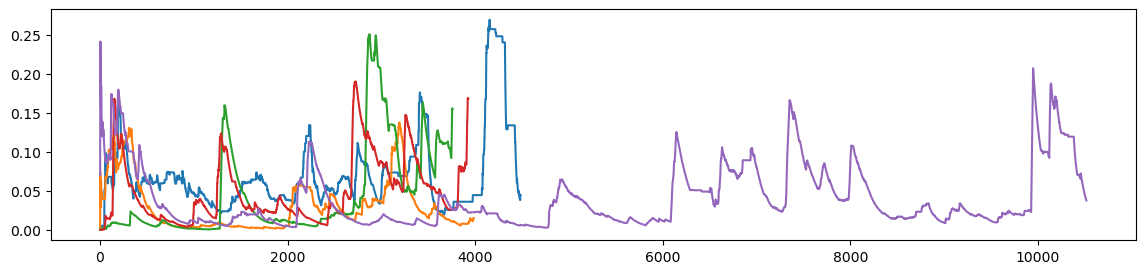

<IPython.core.display.Javascript object>

In [13]:
output_metric(metric=["happy"], dfs=face_data_signals, smooth_span=smoothing_window)

In [14]:
attr_merged_df = merge_on_metric(
    face_data_signals=face_data_signals,
    attr_name="happy",
    column_names=data_files,
    smoothing_window=smoothing_window,
    min_len=min_len,
)

<IPython.core.display.Javascript object>

<Axes: >

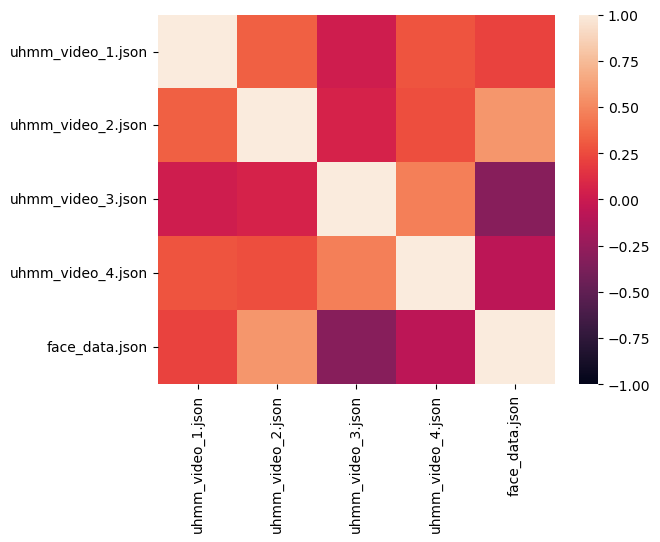

<IPython.core.display.Javascript object>

In [15]:
straight_corr = attr_merged_df.corr()
sns.heatmap(
    straight_corr, vmin=-1, vmax=1,
)

In [16]:
straight_corr

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json
uhmm_video_1.json,1.000000,0.333720,0.016548,0.285378,0.214856
uhmm_video_2.json,0.333720,1.000000,0.055130,0.263313,0.566168
uhmm_video_3.json,0.016548,0.055130,1.000000,0.467160,-0.314532
uhmm_video_4.json,0.285378,0.263313,0.467160,1.000000,-0.072963
face_data.json,0.214856,0.566168,-0.314532,-0.072963,1.000000


<IPython.core.display.Javascript object>

In [17]:
straight_corr.mean()

uhmm_video_1.json    0.370100
uhmm_video_2.json    0.443666
uhmm_video_3.json    0.244861
uhmm_video_4.json    0.388578
face_data.json       0.278706
dtype: float64

<IPython.core.display.Javascript object>

<Axes: >

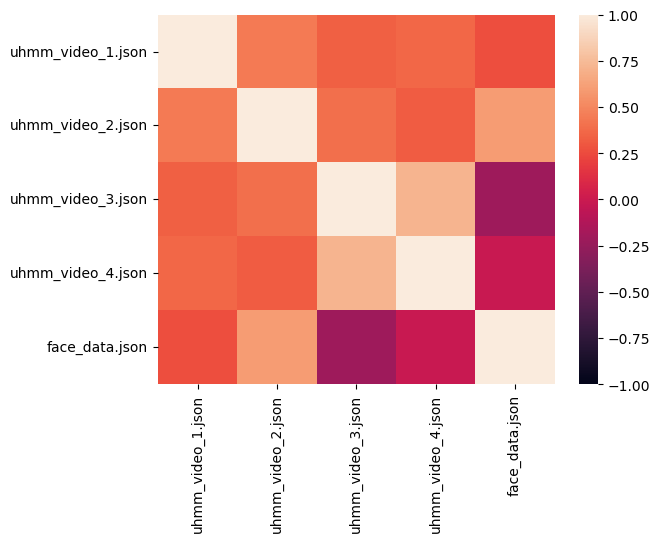

<IPython.core.display.Javascript object>

In [18]:
window_corr = attr_merged_df.corr(method=shifted_corr)
sns.heatmap(
    window_corr, vmin=-1, vmax=1,
)

In [19]:
window_corr

,uhmm_video_1.json,uhmm_video_2.json,uhmm_video_3.json,uhmm_video_4.json,face_data.json
uhmm_video_1.json,1.000000,0.443101,0.334642,0.363992,0.264389
uhmm_video_2.json,0.443101,1.000000,0.390977,0.315290,0.599381
uhmm_video_3.json,0.334642,0.390977,1.000000,0.716492,-0.216920
uhmm_video_4.json,0.363992,0.315290,0.716492,1.000000,-0.009936
face_data.json,0.264389,0.599381,-0.216920,-0.009936,1.000000


<IPython.core.display.Javascript object>

In [58]:
window_corr.mean()

uhmm_video_1.json    0.481225
uhmm_video_2.json    0.549750
uhmm_video_3.json    0.445038
uhmm_video_4.json    0.477168
face_data.json       0.327383
dtype: float64

<IPython.core.display.Javascript object>

## Pair by pair examination

In [62]:
def plot_pairwise_analysis(data, smoothing_span):
    plots_num = 4
    f, ax = plt.subplots(plots_num, 1, figsize=(14, 3 * plots_num))

    ax[0].plot(data)
    ax[1].plot(data.ewm(span=smoothing_span).mean())
    
    rolling_r = (
        metric_pair_merged_df[attr1]
        .rolling(window=smoothing_window, center=True)
        .corr(metric_pair_merged_df[attr2])
    )
    
    

<IPython.core.display.Javascript object>

In [46]:
attr1 = "face_data.json"
attr2 = "uhmm_video_4.json"
metric = "happy"

<IPython.core.display.Javascript object>

In [47]:
metric_pair_merged_df = merge_on_metric(
    face_data_signals=face_data_signals,
    attr_name=metric,
    column_names=data_files,
    smoothing_window=smoothing_window,
    min_len=min_len,
)[[attr1, attr2]]
metric_pair_merged_df.head()

,face_data.json,uhmm_video_4.json
0,NaN,NaN
1,0.070000,NaN
2,0.135217,NaN
3,0.140177,NaN
4,0.241135,0.0


<IPython.core.display.Javascript object>

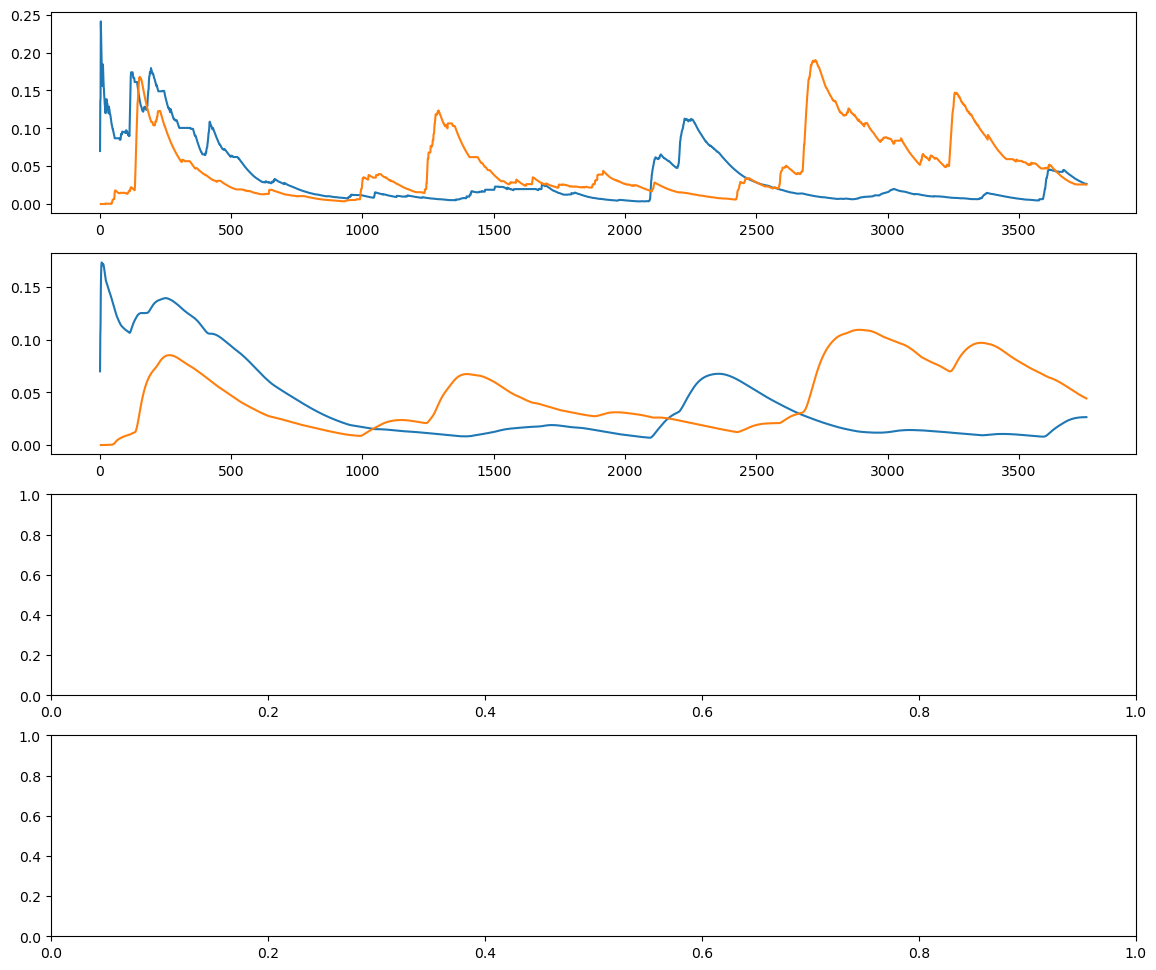

<IPython.core.display.Javascript object>

In [63]:
plot_pairwise_analysis(data=metric_pair_merged_df, smoothing_span=smoothing_window)

0.9814787284980633


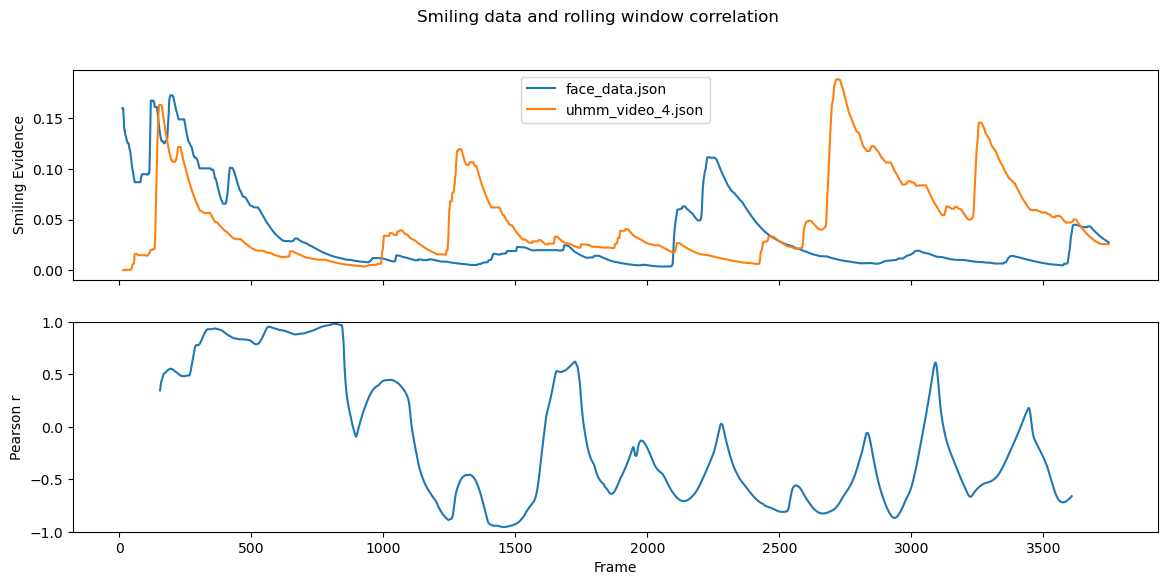

<IPython.core.display.Javascript object>

In [50]:
# Compute rolling window synchrony
rolling_r = (
    metric_pair_merged_df[attr1]
    .rolling(window=smoothing_window, center=True)
    .corr(metric_pair_merged_df[attr2])
)

f, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
metric_pair_merged_df.rolling(window=20, center=True).median().plot(ax=ax[0])
ax[0].set(xlabel="Frame", ylabel="Smiling Evidence")
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel="Frame", ylabel="Pearson r")
ax[1].set_ylim([-1, 1])
plt.suptitle("Smiling data and rolling window correlation")

print(rolling_r.max())

Max corr shift:  278
Max corr: -0.009935936428466447


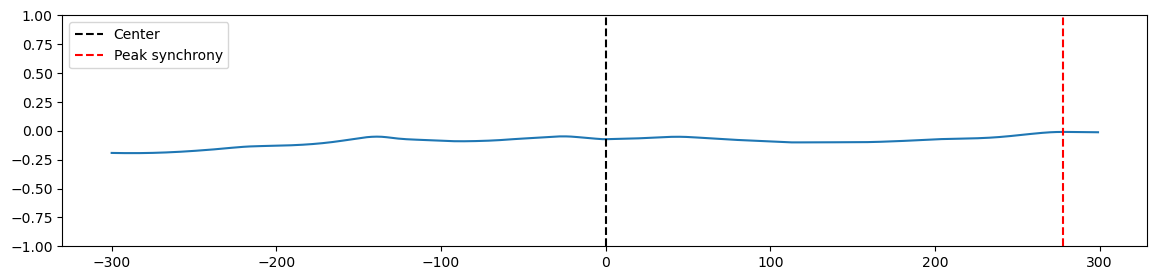

<IPython.core.display.Javascript object>

In [51]:
rs, shift_ranges = get_shifted_correlations(
    data_1=metric_pair_merged_df[attr1],
    data_2=metric_pair_merged_df[attr2],
    shift_window=smoothing_window,
)
max_corr_shift = shift_ranges[np.argmax(rs)]

f, ax = plt.subplots(figsize=(14, 3))
# ax.set_xlim([xmin, xmax])
ax.set_ylim([-1, 1])

ax.plot(shift_ranges, rs)
ax.axvline(0, color="k", linestyle="--", label="Center")
ax.axvline(max_corr_shift, color="r", linestyle="--", label="Peak synchrony")
plt.legend()

print("Max corr shift: ", max_corr_shift)
print("Max corr:", np.max(rs))

<Axes: >

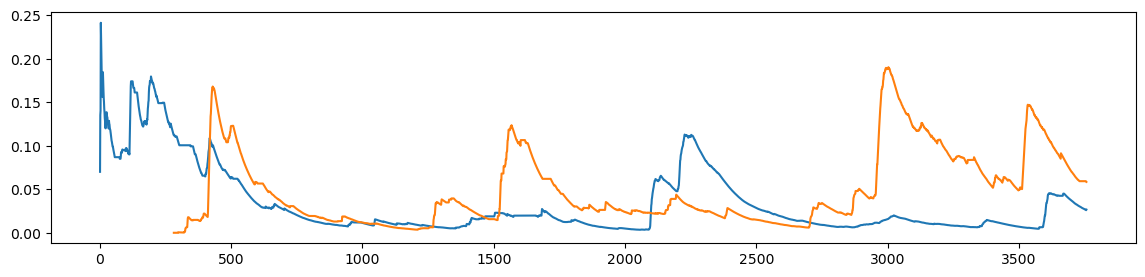

<IPython.core.display.Javascript object>

In [52]:
f, ax = plt.subplots(figsize=(14, 3))
metric_pair_merged_df[attr1].plot()
metric_pair_merged_df[attr2].shift(max_corr_shift).plot()